In [146]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/angry-png/DMUbjq2UjJcG3umGv3Qjjd-1200-80.jpeg
/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv
/kaggle/input/surprise-png/pexels-olly-3777931.jpg
/kaggle/input/laugh-png/laugh.png


In [147]:
import math
import numpy as np
import pandas as pd
import random

import scikitplot
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

random.seed(43)

In [148]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [149]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [150]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [151]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

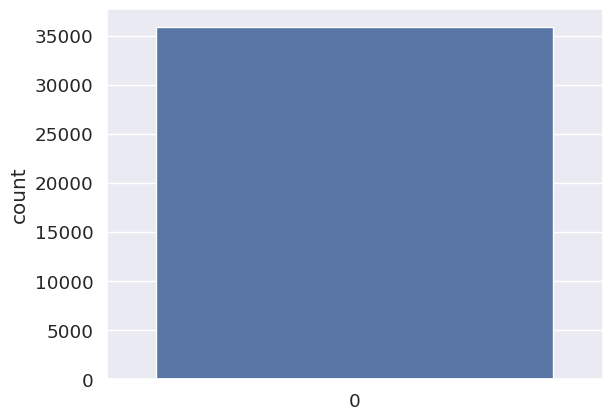

In [152]:
sns.countplot(df.emotion)
plt.show()

In [153]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

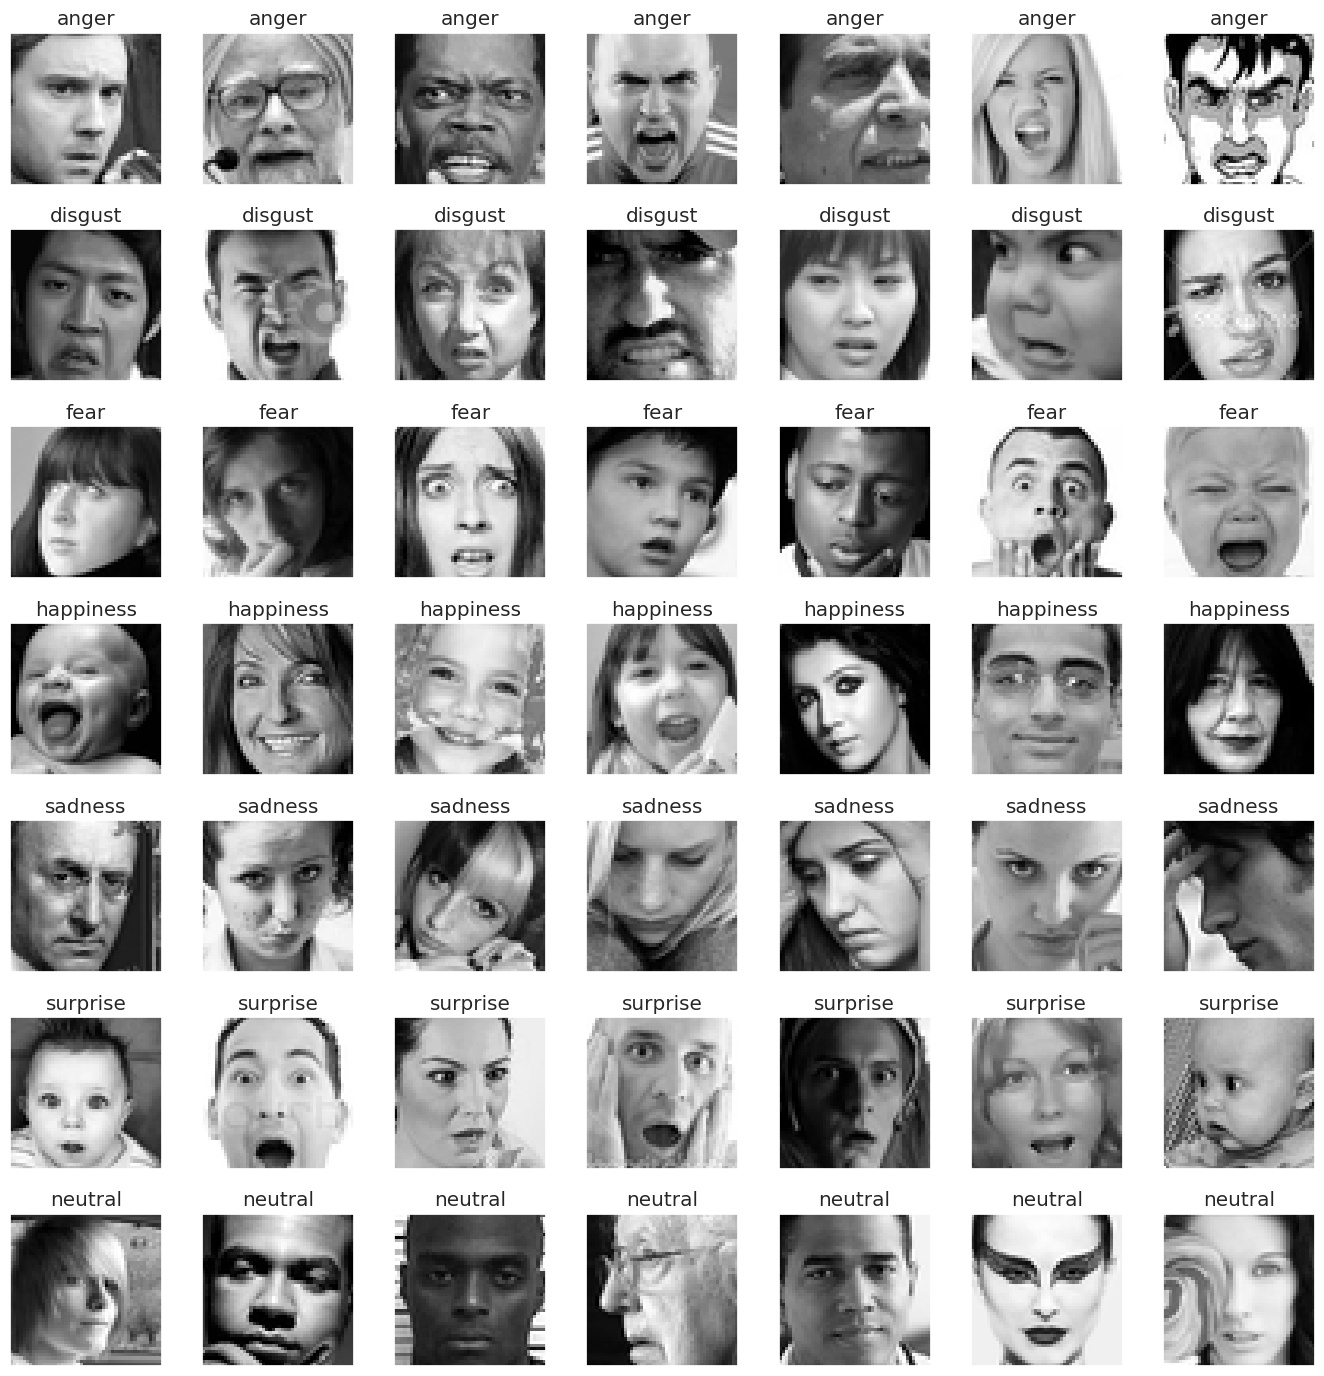

In [154]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [155]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [156]:
img_array.shape

(35887, 48, 48, 1)

In [157]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35887, 7)

In [158]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.10, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [159]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [160]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [161]:
# Create and fit a uniform baseline model
baseline_model_uniform = DummyClassifier(strategy='uniform')
baseline_model_uniform.fit(X_train, y_train)

# Predictions
y_pred_uniform = baseline_model_uniform.predict(X_valid)
accuracy_uniform = accuracy_score(y_valid, y_pred_uniform)
print("Accuracy (Uniform Baseline): {:.2f}".format(accuracy_uniform))

Accuracy (Uniform Baseline): 0.01


## LENET

In [162]:
lenet = Sequential()
lenet.add(Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(48,48,1)))
lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
lenet.add(Conv2D(16, kernel_size=(5, 5), activation='tanh'))
lenet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
lenet.add(Flatten())
lenet.add(Dense(120, activation='tanh'))
lenet.add(Dense(84, activation='tanh'))
lenet.add(Dense(num_classes, activation='softmax'))

lenet.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 44, 44, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1296)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │       155,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,971 (660.04 KB)

 Trainable params: 168,971 (660.04 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
lenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

# Train the model using the data generator
history = lenet.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,  # Assuming 128 is your batch size
                    epochs=25,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.2571 - loss: 1.7970 - val_accuracy: 0.3447 - val_loss: 1.6584
Epoch 2/25
   1/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.3750 - loss: 1.6557

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step - accuracy: 0.3750 - loss: 1.6557 - val_accuracy: 0.3435 - val_loss: 1.6578
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3138 - loss: 1.7165 - val_accuracy: 0.3781 - val_loss: 1.5940
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.3750 - loss: 1.5485 - val_accuracy: 0.3798 - val_loss: 1.5902
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3309 - loss: 1.6791 - val_accuracy: 0.4004 - val_loss: 1.5524
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step - accuracy: 0.4062 - loss: 1.5992 - val_accuracy: 0.3984 - val_loss: 1.5520
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.3484 - loss: 1.6482 - val_accuracy: 0.4062 - val_loss: 1.5528
Epoch 8/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.4375 - loss: 1.5154 - val_accuracy: 0.4021 - val_loss: 1.5479
Epoch 9/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3597 - loss: 1.61

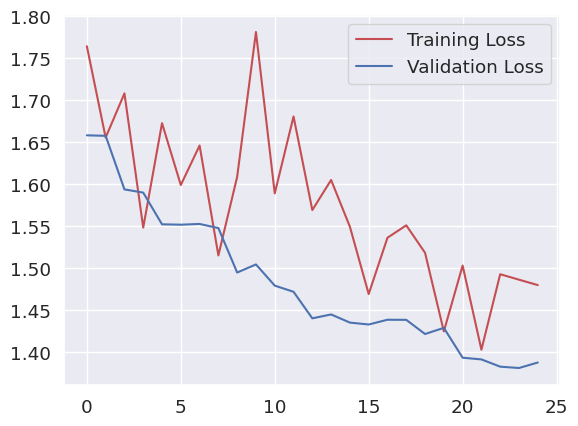

In [164]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

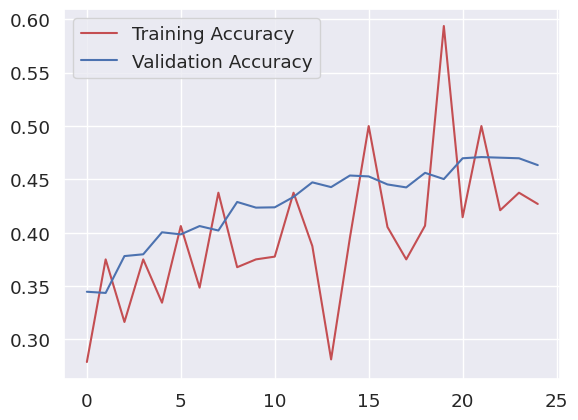

In [165]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [166]:
preds = lenet.predict(X_valid)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


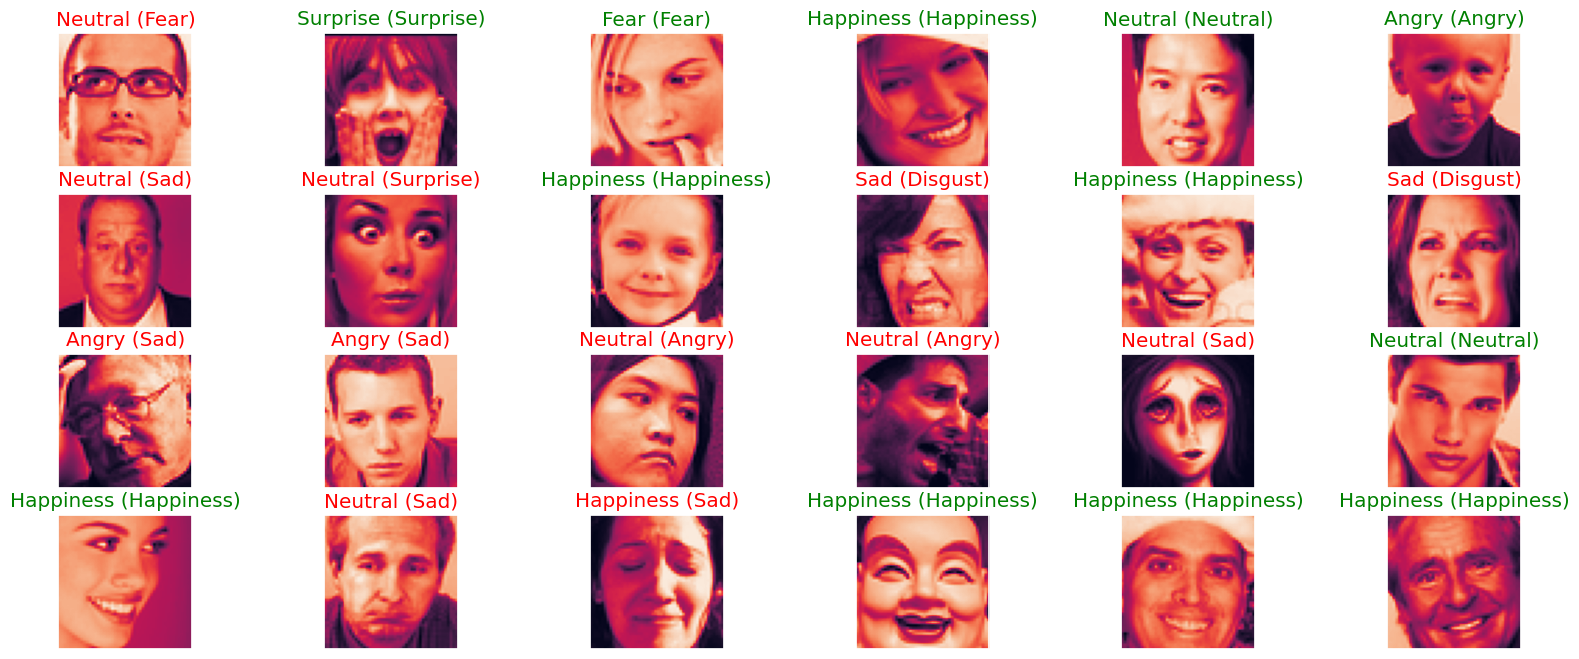

In [167]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_valid.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_valid[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_valid,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

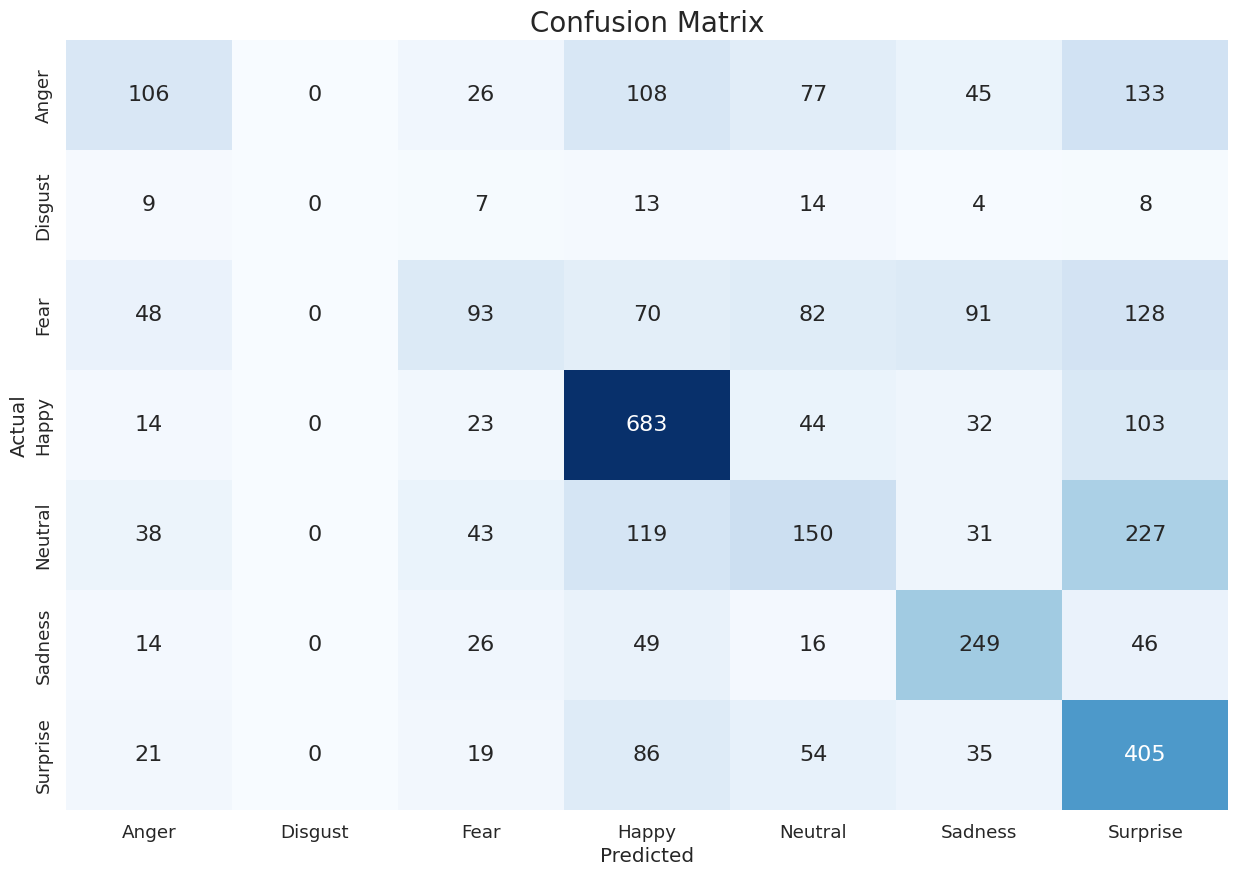

In [168]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_valid, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

## Custom DCNN Model

In [169]:
def build_net():
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.3, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.3, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.3, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.5, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy','precision']
    )
    
    net.summary()
    
    return net

In [170]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    verbose=1,
    restore_best_weights=True,
    start_from_epoch=20,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [171]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [172]:
batch_size = 64 #batch size of 32 performs the best.
epochs = 50

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net() 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,329,031 (8.88 MB)

 Trainable params: 2,326,983 (8.88 MB)

 Non-trainable params: 2,048 (8.00 KB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


504/504 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.2165 - loss: 2.2858 - precision: 0.2485 - val_accuracy: 0.3037 - val_loss: 1.6790 - val_precision: 0.7603 - learning_rate: 0.0010
Epoch 2/50
  1/504 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.3594 - loss: 1.5648 - precision: 0.7273

W0000 00:00:1714420796.584152     158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3594 - loss: 1.5648 - precision: 0.7273 - val_accuracy: 0.3162 - val_loss: 1.6622 - val_precision: 0.7785 - learning_rate: 0.0010
Epoch 3/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3623 - loss: 1.6337 - precision: 0.6236 - val_accuracy: 0.4614 - val_loss: 1.4082 - val_precision: 0.7279 - learning_rate: 0.0010
Epoch 4/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4375 - loss: 1.4092 - precision: 0.8421 - val_accuracy: 0.4687 - val_loss: 1.3860 - val_precision: 0.7302 - learning_rate: 0.0010
Epoch 5/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.4641 - loss: 1.4043 - precision: 0.7229 - val_accuracy: 0.5322 - val_loss: 1.2242 - val_precision: 0.7268 - learning_rate: 0.0010
Epoch 6/50
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5781 - loss: 1.2641 - precision: 0.7083 - val_accuracy: 0.5286 - val_loss: 1.2265 - val_precision: 0.7256 - learning_rate: 0.0010
Epoch 7/50
504/504 ━━━━━━━━

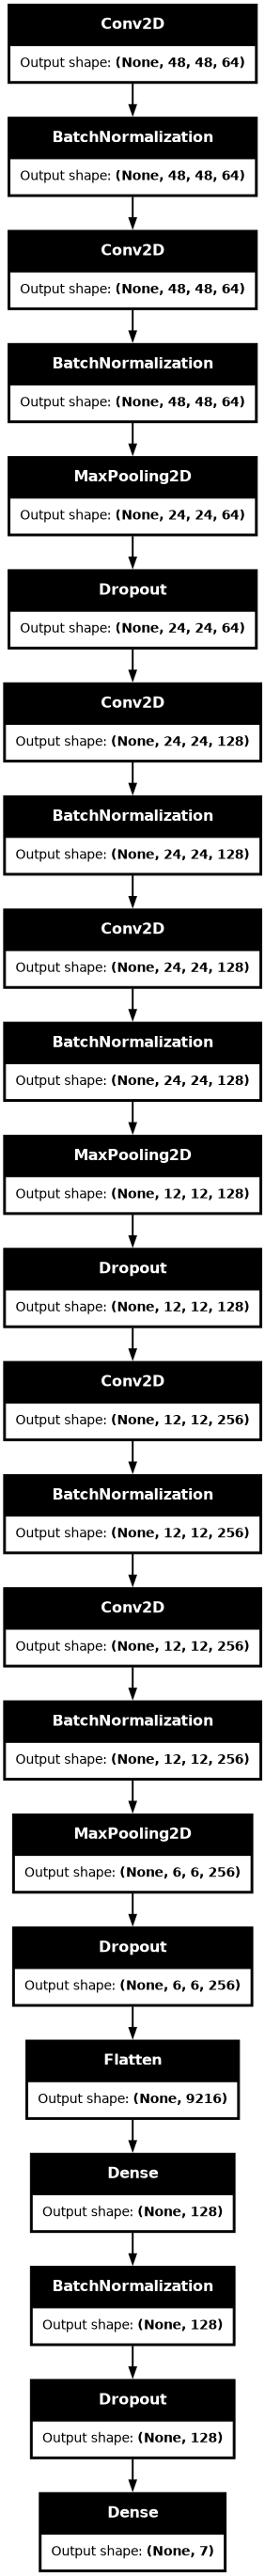

In [173]:
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=False,dpi=70)

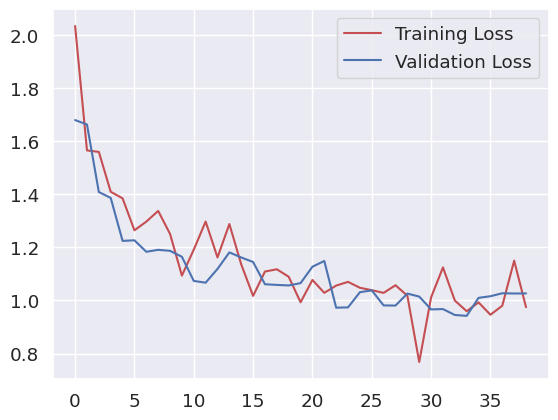

In [174]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()


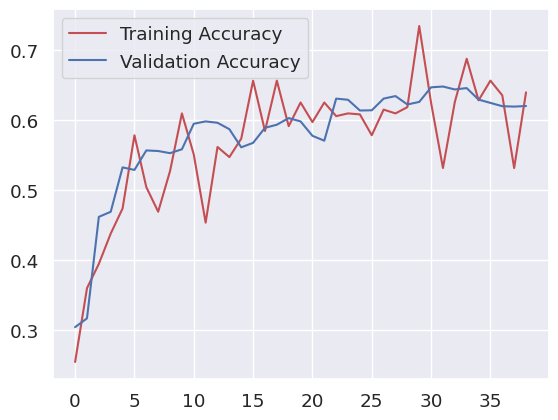

In [175]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

In [176]:
preds = model.predict(X_valid)
y_pred = np.argmax(preds , axis = 1 )

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


W0000 00:00:1714421115.534727     157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


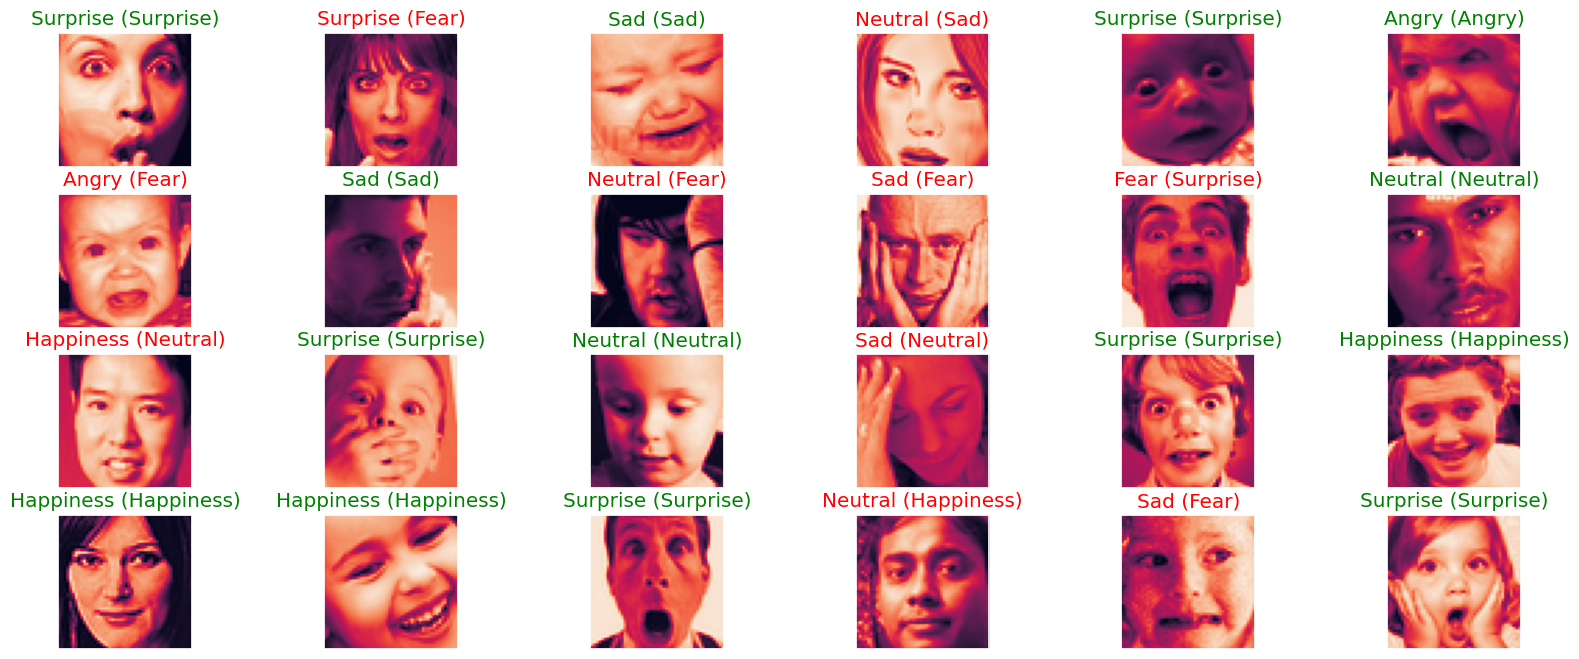

In [177]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_valid.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_valid[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_valid,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

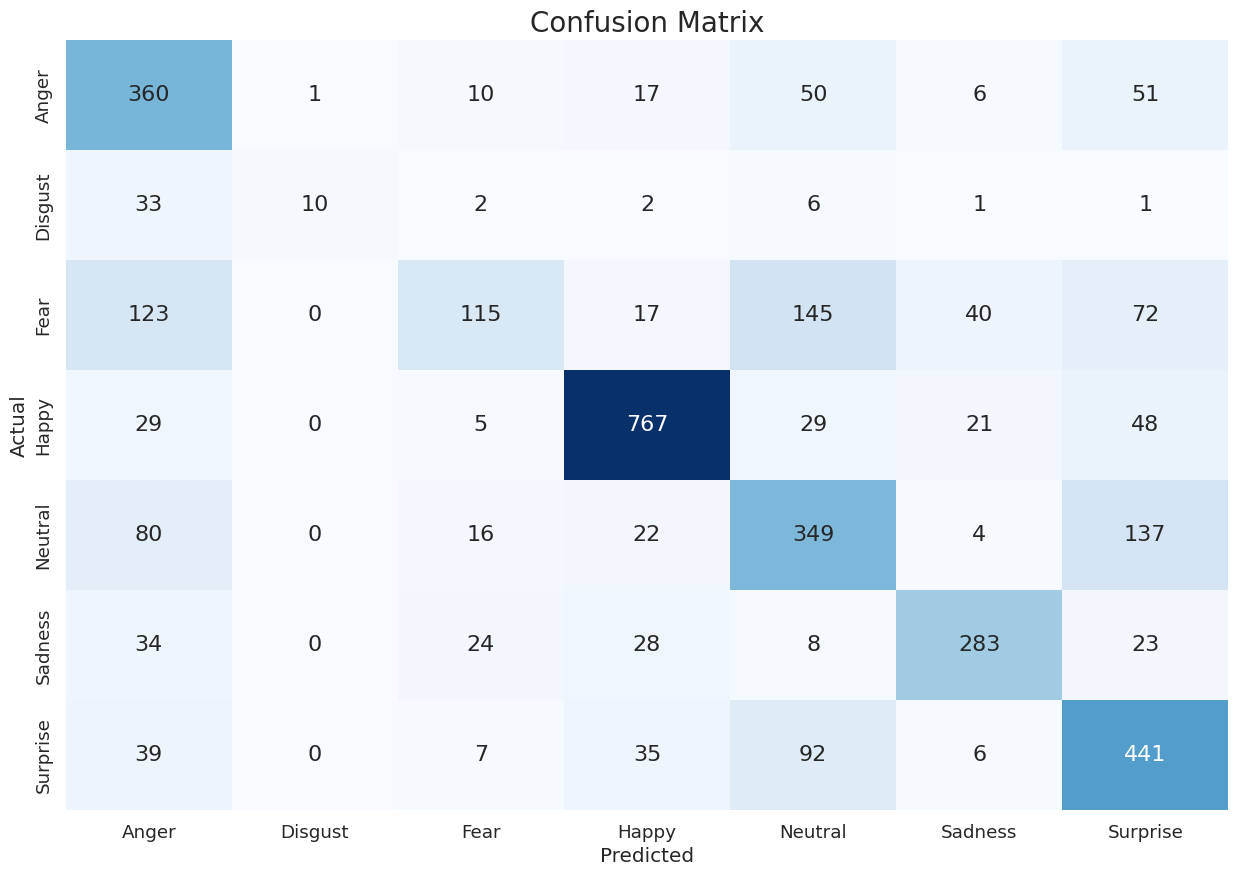

In [178]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_valid, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [179]:
from PIL import Image

image_path = '/kaggle/input/angry-png/DMUbjq2UjJcG3umGv3Qjjd-1200-80.jpeg'
image = Image.open(image_path)

# Resize the image to (48, 48) using Pillow
image_resized = image.resize((48, 48))

# Convert the image to grayscale
image_grayscale = image_resized.convert("L")

# Convert the grayscale image to a NumPy array
image_array = np.array(image_grayscale)

# Ensure the size of the reshaped array matches the original image size
assert image_array.shape == (48, 48), "Image size is not compatible with the model's input shape (48, 48)"

# Reshape the image array to add a single channel dimension
image_array = np.expand_dims(image_array, axis=-1)

# Normalize the pixel values (optional, but often necessary)
image_array = image_array / 255.0

# Add batch dimension to match model's input shape
image_array = np.expand_dims(image_array, axis=0)

# Now, the shape of the image array should be (1, 48, 48, 1)
print("Shape of preprocessed image:", image_array.shape)


Shape of preprocessed image: (1, 48, 48, 1)


In [180]:
history = model.predict(image_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step


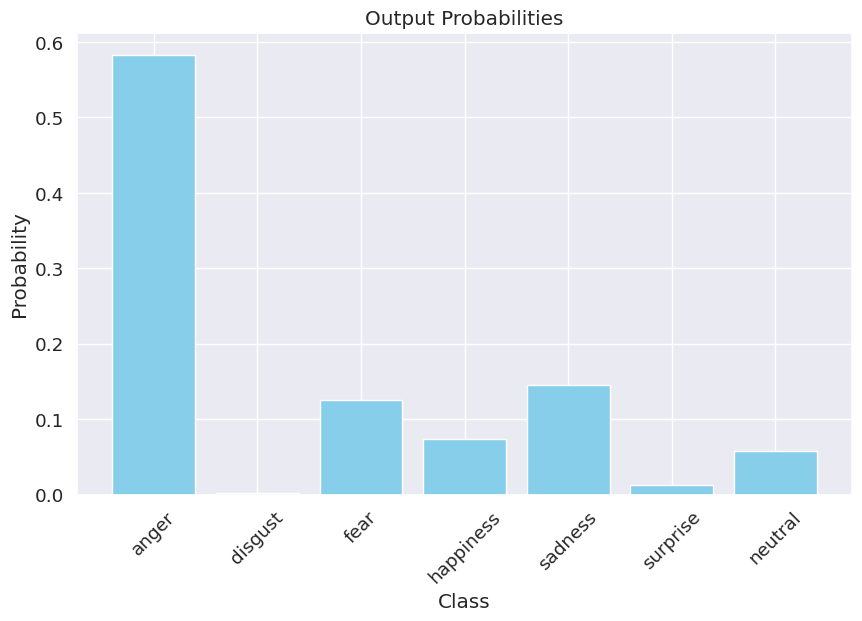

In [181]:
import matplotlib.pyplot as plt

# Class labels (replace with your actual class labels)
class_labels = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

# Output probabilities
output_probabilities = history[0]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_labels, output_probabilities, color='skyblue')
plt.title('Output Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()